# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [1]:
# Загрузим необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Загрузим CVS-файл в датасет 'sessions_history'
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

In [3]:
# Выведем первые 5 строк полученого датасета
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [4]:
# Рассчитываем количество уникальных сессий для каждого пользователя
unique_sessions_count = sessions_history.groupby('user_id')['session_id'].nunique()

In [5]:
# Находим пользователя с наибольшим количеством уникальных сессий
max_sessions_user_id = unique_sessions_count.idxmax()
max_sessions_count = unique_sessions_count.max()
print(f'Пользователь с ID {max_sessions_user_id} имеет наибольшее количество уникальных сессий: {max_sessions_count}')

Пользователь с ID 10E0DEFC1ABDBBE0 имеет наибольшее количество уникальных сессий: 10


In [6]:
# Получаем данные за все сессии для этого пользователя
user_data = sessions_history[sessions_history['user_id'] == max_sessions_user_id]
display(user_data)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


Пользователь с наибольшим кол-вом сессий, пользовался приложением с телефона, он зарегестрировался в августе и в этом же месяце было больше всего сессий. Пользователь из СНГ. Важно отметить, что пользовател пользовался продуктом без регистрации. 

#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

In [7]:
sessions_history['session_day'] = pd.to_datetime(sessions_history['session_date']).dt.date

day_session_history = sessions_history[sessions_history['registration_flag']==1]

group_sessions_reg = day_session_history.groupby('session_day')['user_id'].nunique()

group_sessions_uniq = sessions_history.groupby('session_day')['user_id'].nunique()


In [8]:
daily_stats = pd.merge(group_sessions_uniq, group_sessions_reg, on='session_day', how='left').fillna(0)

In [9]:
dayli_percent = round((daily_stats['user_id_y'] / daily_stats['user_id_x'])*100,2)

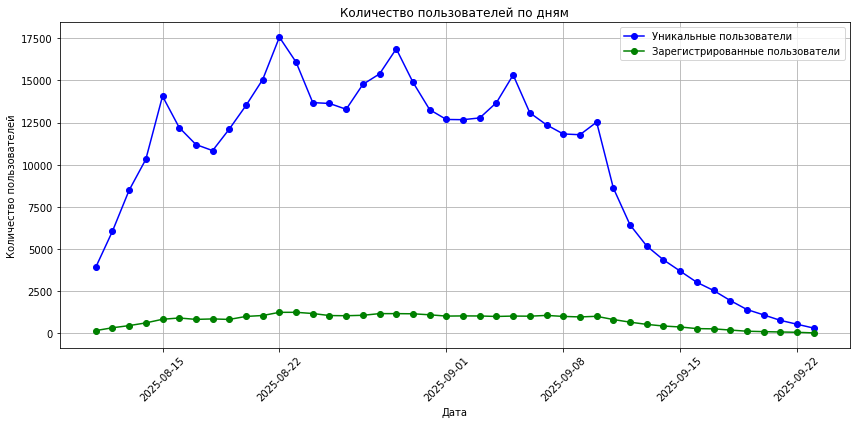

In [10]:

# Создание линейного графика
plt.figure(figsize=(12, 6))

plt.plot(daily_stats.index, group_sessions_uniq, label='Уникальные пользователи', color='blue', marker='o')
plt.plot(daily_stats.index, group_sessions_reg, label='Зарегистрированные пользователи', color='green', marker='o')

# Настройка графика
plt.title('Количество пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Показать график
plt.tight_layout()
plt.show()

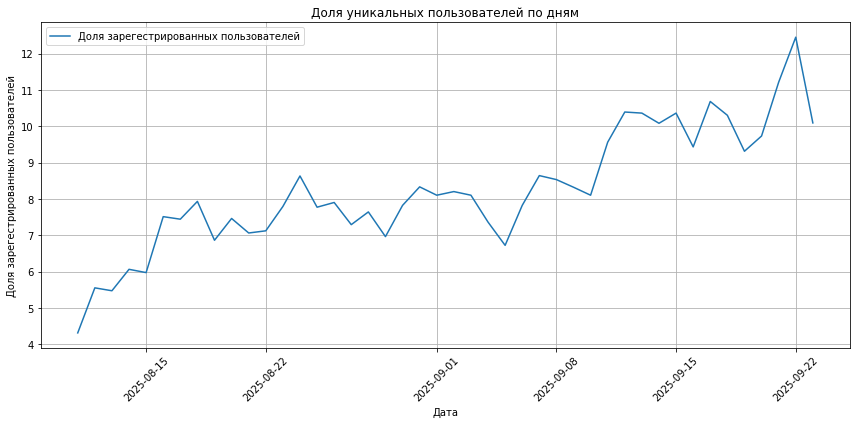

In [11]:

# Создание линейного графика
plt.figure(figsize=(12, 6))

dayli_percent.plot(kind='line', label='Доля зарегестрированных пользователей')

# Настройка графика
plt.title('Доля уникальных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Доля зарегестрированных пользователей')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Показать график
plt.tight_layout()
plt.show()

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29160 сессиях, две страницы в 105536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

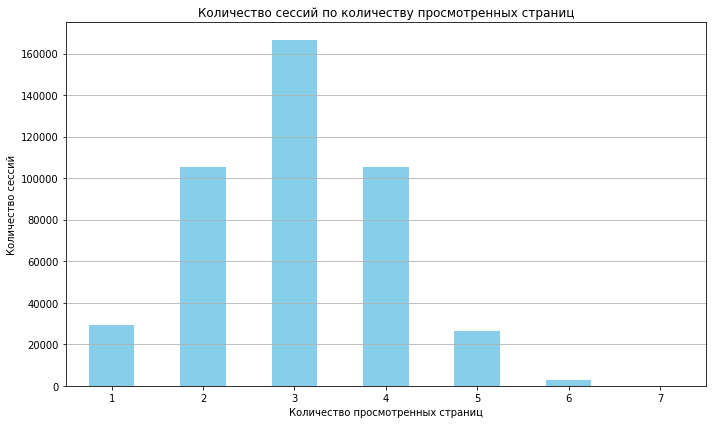

In [12]:
session_counts = sessions_history['page_counter'].value_counts().sort_index()

# Построение столбчатой диаграммы
plt.figure(figsize=(10, 6))
session_counts.plot(kind='bar', color='skyblue')

# Настройка заголовка и подписей
plt.title('Количество сессий по количеству просмотренных страниц')
plt.xlabel('Количество просмотренных страниц')
plt.ylabel('Количество сессий')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Показать диаграмму
plt.tight_layout()
plt.show()

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

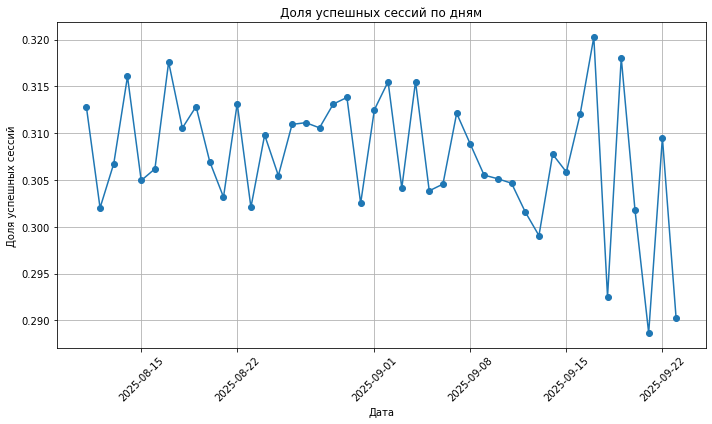

In [13]:
# Создание нового столбца good_session
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype(int)

# Группировка по дате и расчет доли успешных сессий
daily_success_rate = sessions_history.groupby('session_day')['good_session'].mean().reset_index()

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(daily_success_rate['session_day'], daily_success_rate['good_session'], marker='o')
plt.title('Доля успешных сессий по дням')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### 2.1. Расчёт размера выборки
В рамках курса вам уже приходилось рассчитывать размеры выборки, используя онлайн-калькуляторы. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего дизайна эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки мы будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [14]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size=mde,
    power=power,
    alpha=alpha,
    ratio=1  # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")


Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [15]:
from math import ceil

# Примерные данные
sample_size = sample_size * 2  # Размер выборки
avg_daily_users = sessions_history.groupby('session_day')['user_id'].nunique().mean() # Среднее количество пользователей приложения в день


# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровне трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")


Рассчитанная длительность A/B-теста при текущем уровне трафика в 9907.363636363636 пользователей в день составит 4 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой можно было бы увидеть возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

Количество уникальных пользователей в группе A: 1477
Количество уникальных пользователей в группе B: 1466
Процентная разница между группами A и B: 0.74%


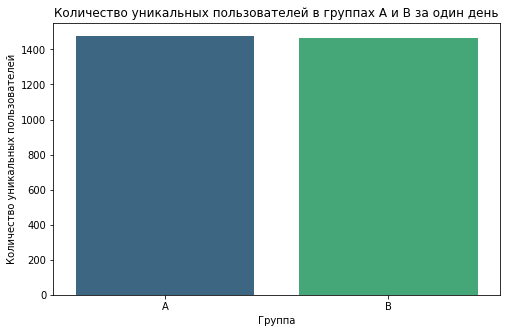

In [16]:

# Считываем данные
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

# Получаем количество уникальных пользователей в группах A и B
unique_users_A = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique()
unique_users_B = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique()
percentage_difference = 100 * ((unique_users_A-unique_users_B)/unique_users_A)

print(f"Количество уникальных пользователей в группе A: {unique_users_A}")
print(f"Количество уникальных пользователей в группе B: {unique_users_B}")
print(f"Процентная разница между группами A и B: {percentage_difference:.2f}%")

# Шаг 4: Визуализация
# Создаем DataFrame для визуализации
results_df = pd.DataFrame({
    'test_group': ['A', 'B'],
    'Unique Users': [unique_users_A, unique_users_B]
})

# Визуализируем данные
plt.figure(figsize=(8, 5))
sns.barplot(x='test_group', y='Unique Users', data=results_df, palette='viridis')
plt.title('Количество уникальных пользователей в группах A и B за один день')
plt.ylabel('Количество уникальных пользователей')
plt.xlabel('Группа')
plt.show()


#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [17]:
A_group = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id']
B_group = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id']

intersection = list(set(B_group) & set(A_group))
print(intersection) 

[]


#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


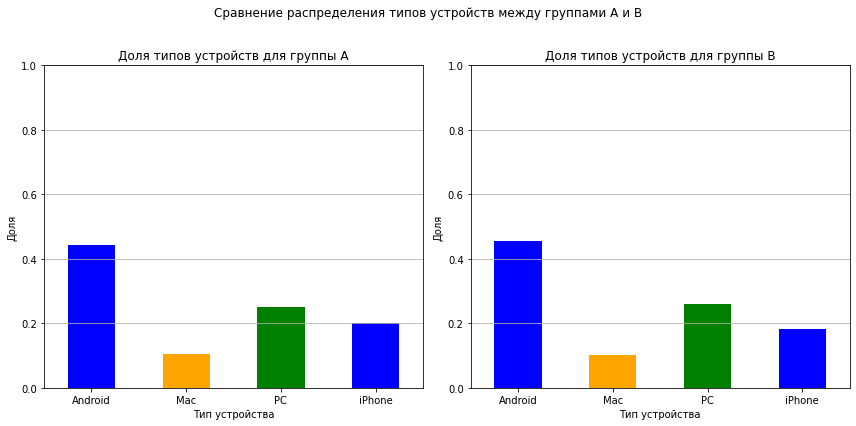

In [18]:
# Подсчет доли каждого типа устройства для каждой группы
device_distribution = sessions_test_part.groupby(['test_group', 'device'])['user_id'].nunique().unstack(fill_value=0)

# Нормализация для получения долей
device_distribution = device_distribution.div(device_distribution.sum(axis=1), axis=0)

# Билдим диаграммы
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# График для группы A
device_distribution.loc['A'].plot(kind='bar', ax=axs[0], color=['blue', 'orange', 'green'])
axs[0].set_title('Доля типов устройств для группы A')
axs[0].set_xlabel('Тип устройства')
axs[0].set_ylabel('Доля')
axs[0].set_ylim(0, 1)
axs[0].set_xticklabels(device_distribution.columns, rotation=0)
axs[0].grid(axis='y')

# График для группы B
device_distribution.loc['B'].plot(kind='bar', ax=axs[1], color=['blue', 'orange', 'green'])
axs[1].set_title('Доля типов устройств для группы B')
axs[1].set_xlabel('Тип устройства')
axs[1].set_ylabel('Доля')
axs[1].set_ylim(0, 1)
axs[1].set_xticklabels(device_distribution.columns, rotation=0)
axs[1].grid(axis='y')

# Добавление общей метки
plt.suptitle('Сравнение распределения типов устройств между группами A и B')

# Показ диаграмм
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


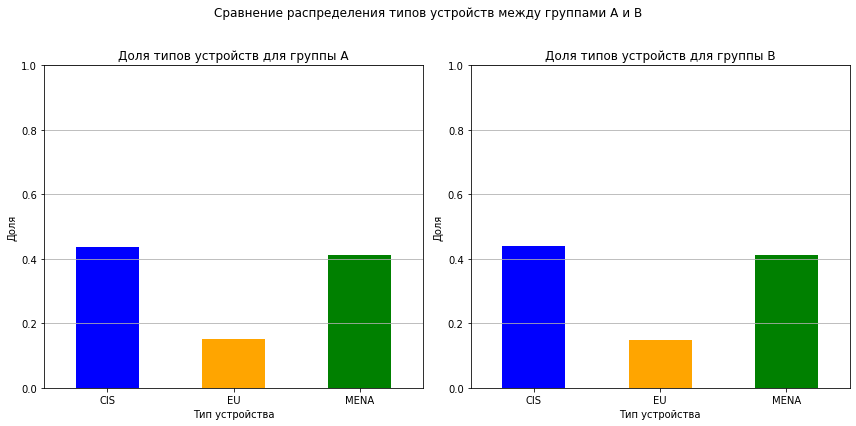

In [19]:
# Подсчет доли каждого типа устройства для каждой группы
device_distribution = sessions_test_part.groupby(['test_group', 'region'])['user_id'].nunique().unstack(fill_value=0)

# Нормализация для получения долей
device_distribution = device_distribution.div(device_distribution.sum(axis=1), axis=0)

# Билдим диаграммы
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# График для группы A
device_distribution.loc['A'].plot(kind='bar', ax=axs[0], color=['blue', 'orange', 'green'])
axs[0].set_title('Доля типов устройств для группы A')
axs[0].set_xlabel('Тип устройства')
axs[0].set_ylabel('Доля')
axs[0].set_ylim(0, 1)
axs[0].set_xticklabels(device_distribution.columns, rotation=0)
axs[0].grid(axis='y')

# График для группы B
device_distribution.loc['B'].plot(kind='bar', ax=axs[1], color=['blue', 'orange', 'green'])
axs[1].set_title('Доля типов устройств для группы B')
axs[1].set_xlabel('Тип устройства')
axs[1].set_ylabel('Доля')
axs[1].set_ylim(0, 1)
axs[1].set_xticklabels(device_distribution.columns, rotation=0)
axs[1].grid(axis='y')

# Добавление общей метки
plt.suptitle('Сравнение распределения типов устройств между группами A и B')

# Показ диаграмм
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Были ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение о том, корректно ли проходит A/B-тест или наблюдаются какие-либо нарушения.

Различия в количестве пользователей:
В ходе анализа A/B-теста было обнаружено, что количество пользователей в тестовой и контрольной группах незначительно отличается. Данное различие является статистически незначимым, и можно утверждать, что обе выборки сопоставимы по количеству.

Независимость выборок:
Выборки являются независимыми, так как в ходе распределения пользователей произошло случайное назначение в тестовую и контрольную группы. При проверке на пересечение пользователей не было выявлено случаев, когда один и тот же пользователь оказывался в обеих группах.

Равномерное распределение по категориальным переменным:
При анализе распределения пользователей по устройствам и регионам было установлено, что тестовая и контрольная группы представляют собой аналогичные пропорции для обоих категориальных переменных.

Заключение о корректности A/B-теста:
На основании вышеизложенного можно заключить, что A/B-тест проходит корректно. Выборки независимы, отсутствуют пересечения пользователей, а распределение по категориальным переменным является равномерным. Следовательно, результаты теста можно считать достоверными, что позволяет продолжать анализ для оценки влияния тестируемого изменения на поведение пользователей.

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [20]:
# Чтение CSV-файла и создание датафрейма
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

# Создание нового столбца good_session
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

In [21]:

# Группировка данных и подсчет уникальных сессий
unique_sessions = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().reset_index()

# Пивотирование таблицы для получения уникальных сессий по группам
pivot_table = unique_sessions.pivot(index='session_date', columns='test_group', values='session_id').fillna(0)

# Получение уникальных сессий для каждой группы
group_a = pivot_table['A']
group_b = pivot_table['B']

# Проведение t-теста для сравнения средних значений
t_stat, p_value = stats.ttest_ind(group_a, group_b, equal_var=False)

# Вывод результатов
print(f'p-value: {p_value}')

# Интерпретация p-value
alpha = 0.05  # уровень значимости
if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Существует статистически значимая разница между группами.")
else:
    print("Не отвергаем нулевую гипотезу. Различия между группами не статистически значимы.")


p-value: 0.9382195854082714
Не отвергаем нулевую гипотезу. Различия между группами не статистически значимы.


#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [22]:
# Расчет доли успешных сессий для каждой группы
success_rate = sessions_test.groupby('test_group')['good_session'].mean()

# Разница между долями успешных сессий
difference = success_rate['A'] - success_rate['B']

# Вывод результатов
print(f"Доля успешных сессий для группы A: {success_rate['A']:.3f}")
print(f"Доля успешных сессий для группы B: {success_rate['B']:.3f}")
print(f"Разница в долях: {difference*100:.1f}%")

Доля успешных сессий для группы A: 0.308
Доля успешных сессий для группы B: 0.318
Разница в долях: -1.1%


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

In [27]:
n_count = sessions_test["test_group"].value_counts()


n1 = n_count['A'] # количество сессий в контрольной группе
n2 = n_count['B'] # количество сессий в тестовой группе
successes1 = int(n1 * 0.308)  # например, 30% успешных сессий в контрольной группе
successes2 = int(n2 * 0.318)  # например, 31.1% успешных сессий в тестовой группе



# Выполнение Z-теста
count = np.array([successes1, successes2])
nobs = np.array([n1, n2])

z_stat, p_value = proportions_ztest(count, nobs)

# Вывод результатов
print(f'p-value: {p_value}')

# Проверка на статистическую значимость
alpha = 0.05  # уровень значимости
if p_value < alpha:
    print('Результат статистически значим, отклоняем нулевую гипотезу.')
else:
    print('Нет оснований для отклонения нулевой гипотезы, результаты не статистически значимы.')

p-value: 0.0006450512685631518
Результат статистически значим, отклоняем нулевую гипотезу.


#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять новоовведение в приложение.

Характеристики проведённого эксперимента:

В эксперименте участвовало 17441 пользователей.
Длительность эксперимента составила 2 дней.
Влияние нового алгоритма рекомендаций:

Внедрение нового алгоритма привело к росту ключевой метрики. Анализ показал, что пользователи, которым были представлены рекомендации по новому алгоритму, проявили более высокий уровень вовлеченности по сравнению с контрольной группой.
Статистическая значимость:
Значение p-value для оценки статистической значимости выявленного эффекта составило 0.0006. Это значение меньше уровня значимости 0.05, что позволяет с высокой долей уверенности утверждать, что изменение не является следствием случайных факторов, а действительно обусловлено внедрением нового алгоритма.
Рекомендация по внедрению:
Учитывая полученные результаты, а именно позитивное влияние на ключевую метрику и статистическую значимость выявленного эффекта, рекомендуем внедрить новый алгоритм рекомендаций в приложение. Вероятное увеличение вовлеченности пользователей и улучшение показателей приложения оправдывают переход на новые алгоритмы.
В целом, эксперимент показал успешность нового подхода и его потенциальную ценность для бизнеса.